# **Data Cleaning**

In [ ]:
# Import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Read in the data

data = pd.read_excel("pwt100.xlsx", sheet_name = "Data", header = 0)

# Clean the data

#Select the country to analyse
country_selection = "Germany"

# Extract relevant columns
data = data.loc[:, ("country", "year", "rgdpna", "pop", "rnna", "emp", "hc")]

# Calculate GDP per capita and per worker
data["rgdpna_pc"] = data["rgdpna"] / data["pop"]
data["rgdpna_pw"] = data["rgdpna"] / data["emp"]

# Filter for the country of choice
data = data.loc[data["country"] == country_selection,:]
data = data.reset_index(drop = True)

# Remove rows with missing data
ymax = data.loc[data["rgdpna"] > 0, "year"].max()
ymin = data.loc[data["rgdpna"] > 0, "year"].min()
data = data.loc[data["year"] >= ymin, :]

# Reindex data
data.reset_index(drop=True, inplace=True)

# Check ymax and ymin are correct
if ymin == data["year"].min():
  print("ymin correct")
else:
  print("ymin incorrect")

if ymax == data["year"].max():
  print("ymax correct")
else:
  print("ymax incorrect")

print("Unique years in the data:", data["year"].unique())

# Check structure of data is what is expected
data.head()

ymin correct
ymax correct
Unique years in the data: [1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]


,country,year,rgdpna,pop,rnna,emp,hc,rgdpna_pc,rgdpna_pw
0,Germany,1950,495205.0000,68.734097,1918304.625,30.855808,2.426997,7204.648339,16049.004319
1,Germany,1951,543256.9375,69.073867,2051990.875,31.436510,2.469304,7864.869267,17281.082920
2,Germany,1952,593964.5000,69.448821,2209629.750,32.024281,2.512348,8552.549804,18547.317530
3,Germany,1953,646873.8125,69.846895,2367170.500,32.835850,2.556143,9261.310953,19700.230607
4,Germany,1954,697127.4375,70.264068,2552261.250,33.835823,2.587326,9921.535351,20603.235697


# **Trend paths**

In [ ]:
# Define regression function

def regression_coefs(Y, *args):
    T = len(Y)

    X = np.concatenate([arg[:, None] for arg in args], axis=1)

    XX = X.T @ X
    XY = X.T @ Y

    coefs = np.linalg.inv(XX) @ XY
    return coefs


In [ ]:
# Calculate the trend time paths for (the natural log of) real GDP

rgdpna = data["rgdpna"]

Y = rgdpna
T = len(Y)

# Calculate each trend line before deciding which is most suitable

# Additive linear Model: y = a + bt + u
x1 = np.empty(T)
x2 = np.empty(T)

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1

a_add_lin, b_add_lin = regression_coefs(Y, x1, x2)

rgdpna_add_lin = np.empty(T)

for t in range(T):
    rgdpna_add_lin[t] = a_add_lin + b_add_lin * (t + 1)

# Additive quadratic Model: y = a + bt + ct^2 + u
x1, x2, x3 = [np.empty(T) for j in range(3)]

for t in range(T):
    x1[t] = 1.
    x2[t] = t+1
    x3[t] = t**2

a_add_quad, b1_add_quad, b2_add_quad = regression_coefs(Y, x1, x2, x3)

rgdpna_add_quad = np.empty(T)

for t in range(T):
    rgdpna_add_quad[t] = a_add_quad + b1_add_quad * (t+1) + b2_add_quad * (t**2)

# Exponential linear Model: ln(y) = a + bt + u
x1, x2 = np.empty(T), np.empty(T)

for t in range(T):
    x1[t] = 1.
    x2[t] = t+1

a_exp_lin, b_exp_lin = regression_coefs(np.log(Y), x1, x2)

rgdpna_exp_lin = np.empty(T)

for t in range(T):
    rgdpna_exp_lin[t] = a_exp_lin + b_exp_lin * (t-1)

# Exponential quadratic model: ln(y) = a + bt + ct^2 + u
x1, x2, x3 = [np.empty(T) for j in range(3)]

for t in range(T):
    x1[t] = 1.
    x2[t] = t+1
    x3[t] = t**2

a_exp_quad, b1_exp_quad, b2_exp_quad = regression_coefs(np.log(Y), x1, x2, x3)

rgdpna_exp_quad = np.empty(T)

for t in range(T):
    rgdpna_exp_quad[t] = a_exp_quad + b1_exp_quad * (t+1) + b2_exp_quad * (t**2)


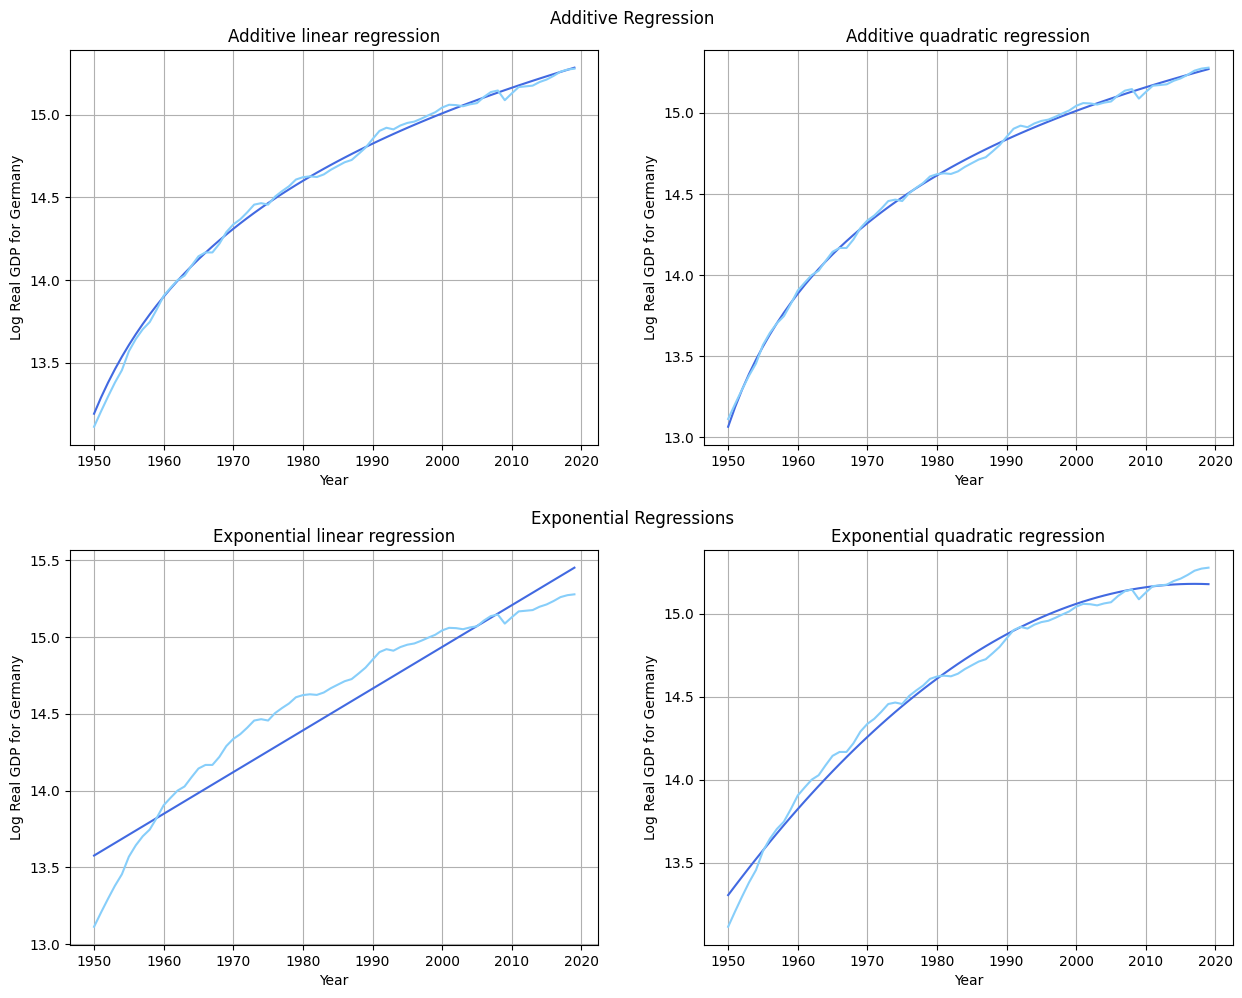

In [ ]:
# Plot the data and trend paths

fig = plt.figure(figsize=(15,10))

(fig1,fig2) = fig.subfigures(2,1)

fig1.suptitle("Additive Regression")
fig1.subplots_adjust(wspace=.2, hspace=0.2, top=0.9)

(ax1,ax2) = fig1.subplots(1,2)

ax1.plot(data["year"], np.log(rgdpna_add_lin), color="royalblue")
ax1.plot(data["year"], np.log(data["rgdpna"]), color="lightskyblue")
ax1.set_title("Additive linear regression")
ax1.set_xlabel("Year")
ax1.set_ylabel("Log Real GDP for " + country_selection)
ax1.ticklabel_format(style="plain", axis="y")
ax1.grid(True)

ax2.plot(data["year"], np.log(rgdpna_add_quad), color="royalblue")
ax2.plot(data["year"], np.log(data["rgdpna"]), color="lightskyblue")
ax2.set_title("Additive quadratic regression")
ax2.set_xlabel("Year")
ax2.set_ylabel("Log Real GDP for " + country_selection)
ax2.ticklabel_format(style="plain", axis="y")
ax2.grid(True)

fig2.suptitle("Exponential Regressions")
fig2.subplots_adjust(wspace=.2, hspace=0.2, top=0.9)

(ax3,ax4) = fig2.subplots(1,2)

ax3.plot(data["year"], rgdpna_exp_lin, color="royalblue")
ax3.plot(data["year"], np.log(data["rgdpna"]), color="lightskyblue")
ax3.set_title("Exponential linear regression")
ax3.set_xlabel("Year")
ax3.set_ylabel("Log Real GDP for " + country_selection)
ax3.ticklabel_format(style="plain", axis="y")
ax3.grid(True)

ax4.plot(data["year"], rgdpna_exp_quad, color="royalblue")
ax4.plot(data["year"], np.log(data["rgdpna"]), color="lightskyblue")
ax4.set_title("Exponential quadratic regression")
ax4.set_xlabel("Year")
ax4.set_ylabel("Log Real GDP for " + country_selection)
ax4.ticklabel_format(style="plain", axis="y")
ax4.grid(True)

In [ ]:
# Calculate the trend time paths for (the natural log of) real GDP per capita

rgdpna_pc = data["rgdpna_pc"]

Y = rgdpna_pc
T = len(Y)

# Calculate each trend line before deciding which is most suitable

# Additive linear Model
x1 = np.empty(T)
x2 = np.empty(T)

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1

a_add_lin, b_add_lin = regression_coefs(Y, x1, x2)

rgdpna_pc_add_lin = np.empty(T)

for t in range(T):
    rgdpna_pc_add_lin[t] = a_add_lin + b_add_lin * (t + 1)

# Additive quadratic Model
x1, x2, x3 = [np.empty(T) for j in range(3)]

for t in range(T):
    x1[t] = 1.
    x2[t] = t+1
    x3[t] = t**2

a_add_quad, b1_add_quad, b2_add_quad = regression_coefs(Y, x1, x2, x3)

rgdpna_pc_add_quad = np.empty(T)

for t in range(T):
    rgdpna_pc_add_quad[t] = a_add_quad + b1_add_quad * (t+1) + b2_add_quad * (t**2)

# Exponential linear Model
x1, x2 = np.empty(T), np.empty(T)

for t in range(T):
    x1[t] = 1.
    x2[t] = t+1

a_exp_lin, b_exp_lin = regression_coefs(np.log(Y), x1, x2)

rgdpna_pc_exp_lin = np.empty(T)

for t in range(T):
    rgdpna_pc_exp_lin[t] = a_exp_lin + b_exp_lin * (t-1)

# Exponential quadratic model
x1, x2, x3 = [np.empty(T) for j in range(3)]

for t in range(T):
    x1[t] = 1.
    x2[t] = t+1
    x3[t] = t**2

a_exp_quad, b1_exp_quad, b2_exp_quad = regression_coefs(np.log(Y), x1, x2, x3)

rgdpna_pc_exp_quad = np.empty(T)

for t in range(T):
    rgdpna_pc_exp_quad[t] = a_exp_quad + b1_exp_quad * (t+1) + b2_exp_quad * (t**2)

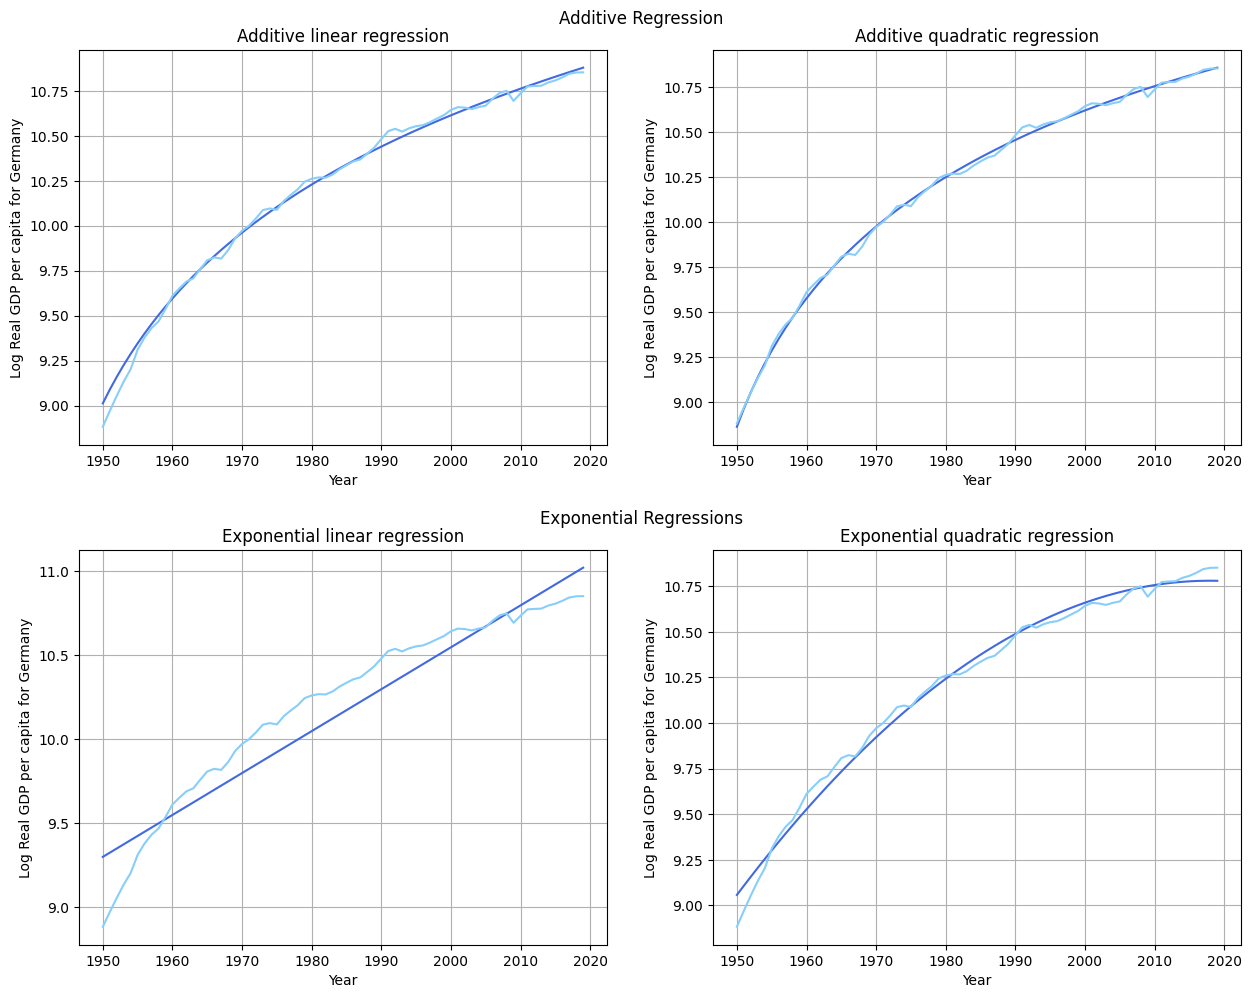

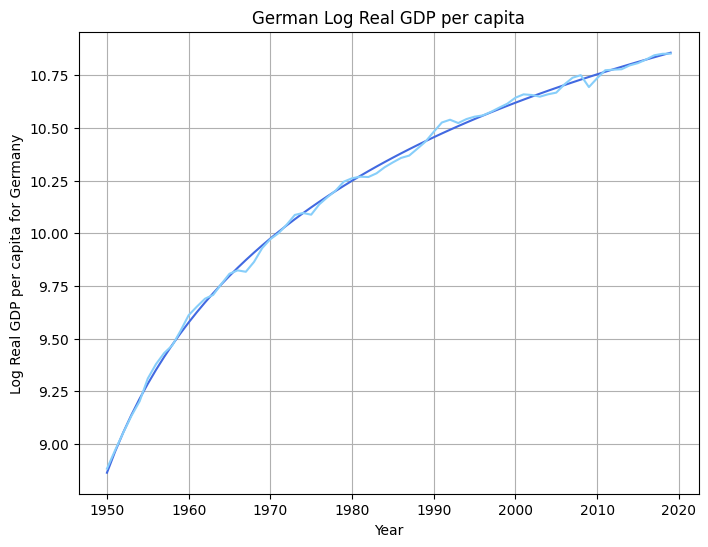

In [ ]:
# Plot the data and trend paths

fig = plt.figure(figsize=(15,10))

(fig1,fig2) = fig.subfigures(2,1)

fig1.suptitle("Additive Regression")
fig1.subplots_adjust(wspace=.2, hspace=0.2, top=0.9)

(ax1,ax2) = fig1.subplots(1,2)

ax1.plot(data["year"], np.log(rgdpna_pc_add_lin), color="royalblue")
ax1.plot(data["year"], np.log(data["rgdpna_pc"]), color="lightskyblue")
ax1.set_title("Additive linear regression")
ax1.set_xlabel("Year")
ax1.set_ylabel("Log Real GDP per capita for " + country_selection)
ax1.ticklabel_format(style="plain", axis="y")
ax1.grid(True)

ax2.plot(data["year"], np.log(rgdpna_pc_add_quad), color="royalblue")
ax2.plot(data["year"], np.log(data["rgdpna_pc"]), color="lightskyblue")
ax2.set_title("Additive quadratic regression")
ax2.set_xlabel("Year")
ax2.set_ylabel("Log Real GDP per capita for " + country_selection)
ax2.ticklabel_format(style="plain", axis="y")
ax2.grid(True)

fig2.suptitle("Exponential Regressions")
fig2.subplots_adjust(wspace=.2, hspace=0.2, top=0.9)

(ax3,ax4) = fig2.subplots(1,2)

ax3.plot(data["year"], rgdpna_pc_exp_lin, color="royalblue")
ax3.plot(data["year"], np.log(data["rgdpna_pc"]), color="lightskyblue")
ax3.set_title("Exponential linear regression")
ax3.set_xlabel("Year")
ax3.set_ylabel("Log Real GDP per capita for " + country_selection)
ax3.ticklabel_format(style="plain", axis="y")
ax3.grid(True)

ax4.plot(data["year"], rgdpna_pc_exp_quad, color="royalblue")
ax4.plot(data["year"], np.log(data["rgdpna_pc"]), color="lightskyblue")
ax4.set_title("Exponential quadratic regression")
ax4.set_xlabel("Year")
ax4.set_ylabel("Log Real GDP per capita for " + country_selection)
ax4.ticklabel_format(style="plain", axis="y")
ax4.grid(True)

fig = plt.figure(figsize = (8,6))

ax = fig.subplots(1,1)

ax.plot(data["year"], np.log(rgdpna_pc_add_quad), color="royalblue")
ax.plot(data["year"], np.log(data["rgdpna_pc"]), color="lightskyblue")
ax.set_title("German Log Real GDP per capita")
ax.set_xlabel("Year")
ax.set_ylabel("Log Real GDP per capita for " + country_selection)
ax.ticklabel_format(style="plain", axis="y")
ax.grid(True)

Total GDP growth from 1950 to 2019 was 771.1680011308448%
Total GDP per capita growth from 1950 to 2019 was 616.966772047381%


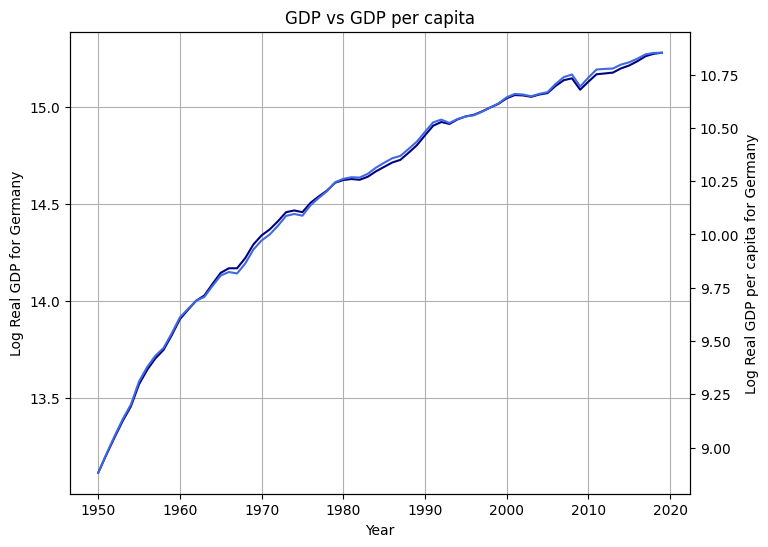

In [ ]:
# Graph of GDP per capita and GDP

fig = plt.figure(figsize=(8,6))

(ax1) = fig.subplots(1,1)

ax1.plot(data["year"], np.log(data["rgdpna"]), label="GDP", color="navy")
ax1.set_title("GDP vs GDP per capita")
ax1.set_xlabel("Year")
ax1.set_ylabel("Log Real GDP for " + country_selection)
ax1.ticklabel_format(style="plain", axis="y")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(data["year"], np.log(data["rgdpna_pc"]), label="GDP per Capita", color="royalblue")
ax2.set_ylabel("Log Real GDP per capita for " + country_selection)

GDP_1950 = data.loc[data['year'] == 1950, 'rgdpna'].values[0]
GDP_2019 = data.loc[data['year'] == 2019, 'rgdpna'].values[0]

GDP_pc_1950 = data.loc[data['year'] == 1950, 'rgdpna_pc'].values[0]
GDP_pc_2019 = data.loc[data['year'] == 2019, 'rgdpna_pc'].values[0]

total_GDP_growth = ((GDP_2019 - GDP_1950) / GDP_1950) * 100
total_GDP_pc_growth = ((GDP_pc_2019 - GDP_pc_1950) / GDP_pc_1950) * 100

print("Total GDP growth from 1950 to 2019 was " + str(total_GDP_growth) + "%")
print("Total GDP per capita growth from 1950 to 2019 was " + str(total_GDP_pc_growth) + "%")

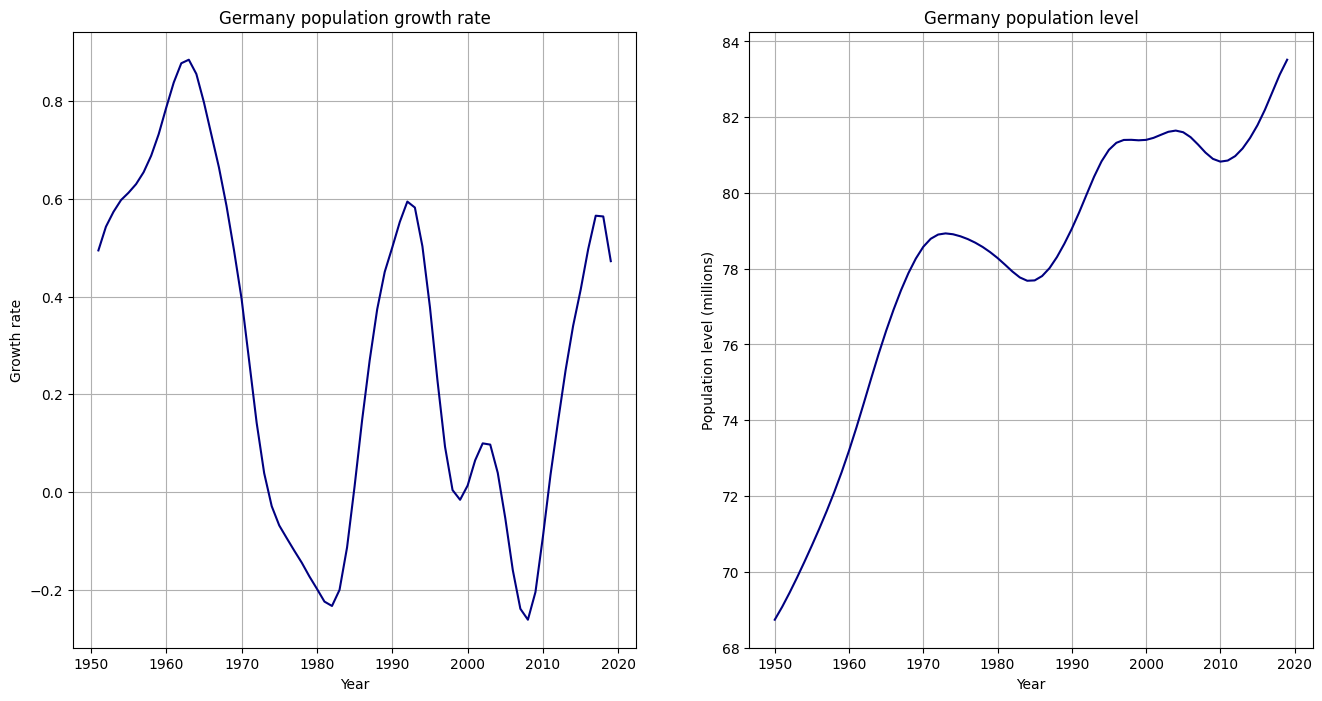

In [ ]:
# Population growth

year = data["year"]
time=len(year)

pop = data["pop"]
pop_growth = np.zeros(time)

for t in range(1, time):
  pop_growth[t] = ((pop[t] - pop[t-1]) / pop[t-1]) * 100

fig = plt.figure(figsize = (16,8))

(ax1, ax2) = fig.subplots(1,2)

ax1.plot(year[1:], pop_growth[1:], label="Population growth rate", color="navy")
ax1.set_title(country_selection + " population growth rate")
ax1.set_xlabel("Year")
ax1.set_ylabel("Growth rate")
ax1.grid(True)

ax2.plot(year, pop, label="Population level", color="navy")
ax2.set_title(country_selection + " population level")
ax2.set_xlabel("Year")
ax2.set_ylabel("Population level (millions)")
ax2.grid(True)

# **Extract TFP measure**

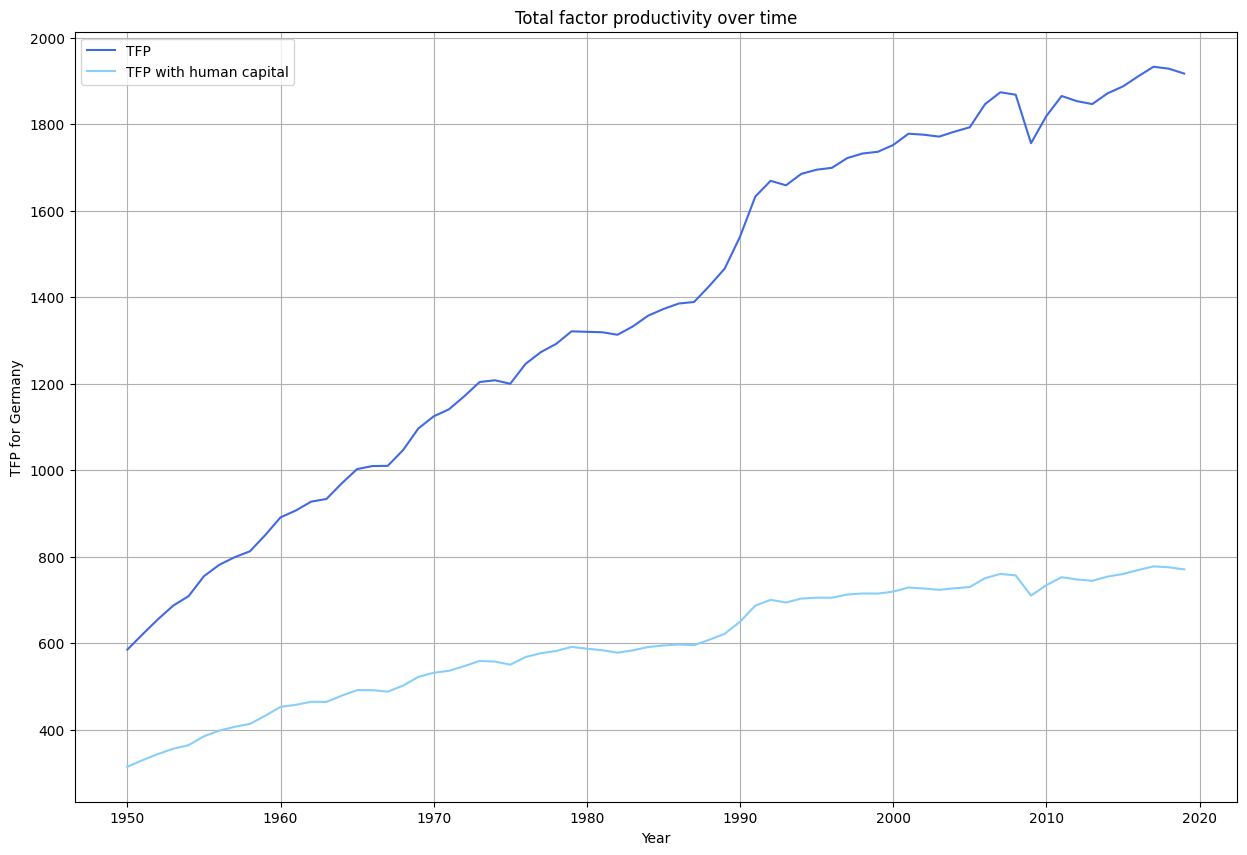

In [ ]:
# Extract TFP measure

alpha = 0.3  # benchmark alpha value

rnna = data["rnna"]  # capital variable
emp = data["emp"]  # labour variable
hc = data["hc"]  # human capital variable

# tfp from cobb-douglas production function without human capital
tfp = rgdpna / ((rnna ** alpha) * (emp ** (1 - alpha)))

# tfp from cobb-douglas production function with human capital
tfp_hc = rgdpna / ((rnna ** alpha) * ((hc * emp) ** (1 - alpha)))

# add new variables to the data frame
data["TFP"] = tfp
data["TFP_hc"] = tfp_hc

# plot the time paths for the new variables
fig = plt.figure(figsize=(15,10))

ax = fig.subplots(1,1)

ax.plot(data["year"], data["TFP"], label="TFP", color='royalblue')
ax.plot(data["year"], data["TFP_hc"], label="TFP with human capital", color='lightskyblue')
ax.set_ylabel("TFP for " + country_selection)
ax.set_xlabel("Year")
ax.set_title("Total factor productivity over time")
ax.legend()
ax.grid(True)

# **Growth Accounting**

In [ ]:
# define a new function to ensure the bar plots are plotted accurately

year = data["year"]

def growth_accounting_plot(ax1, A_g, K_g, L_g, h_g=None, year=year):
    time = len(year)

    for t in range(time):
        if A_g[t] < 0:
            if K_g[t] < 0:
                ax1.bar(year[t], K_g[t] + A_g[t], color="royalblue", zorder=4)
            else:
                ax1.bar(year[t], K_g[t], color="royalblue", zorder=4)
        else:
            if K_g[t] < 0:
                ax1.bar(year[t], K_g[t], color="royalblue", zorder=4)
            else:
                ax1.bar(year[t], K_g[t] + A_g[t], color="royalblue", label="Capital Growth" if t == 0 else "", zorder=4)

        if A_g[t] < 0:
            if K_g[t] < 0:
                if L_g[t] < 0:
                    ax1.bar(year[t], L_g[t] + K_g[t] + A_g[t], color="cornflowerblue", zorder=3)
                else:
                    ax1.bar(year[t], L_g[t], color="cornflowerblue", zorder=3)
            else:
                if L_g[t] < 0:
                    ax1.bar(year[t], A_g[t] + L_g[t], color="cornflowerblue", zorder=3)
                else:
                    ax1.bar(year[t], K_g[t] + L_g[t], color="cornflowerblue", zorder=3)
        else:
            if K_g[t] < 0:
                if L_g[t] < 0:
                    ax1.bar(year[t], K_g[t] + L_g[t], color="cornflowerblue", zorder=3)
                else:
                    ax1.bar(year[t], A_g[t] + L_g[t], color="cornflowerblue", zorder=3)
            else:
                if L_g[t] < 0:
                    ax1.bar(year[t], L_g[t], color="cornflowerblue", zorder=3)
                else:
                    ax1.bar(year[t], L_g[t] + A_g[t] + K_g[t], color="cornflowerblue", label="Employment Growth" if t == 0 else "", zorder=3)
        if h_g is not None:
            if A_g[t] < 0:
                if K_g[t] < 0:
                    if L_g[t] < 0:
                        if h_g[t] < 0:
                            ax1.bar(year[t], A_g[t] + K_g[t] + L_g[t] + h_g[t], color="lightskyblue", zorder=2)
                        else:
                            ax1.bar(year[t], h_g[t], color="lightskyblue", zorder=2)
                    else:
                        if h_g[t] < 0:
                            ax1.bar(year[t], A_g[t] + K_g[t] + h_g[t], color="lightskyblue", zorder=2)
                        else:
                            ax1.bar(year[t], L_g[t] + h_g[t], color="lightskyblue", zorder=2)
                else:
                    if L_g[t] < 0:
                        if h_g[t] < 0:
                            ax1.bar(year[t], A_g[t] + L_g[t] + h_g[t], color="lightskyblue", zorder=2)
                        else:
                            ax1.bar(year[t], K_g[t] + h_g[t], color="lightskyblue", zorder=2)
                    else:
                        if h_g[t] < 0:
                            ax1.bar(year[t], A_g[t] + h_g[t], color="lightskyblue", zorder=2)
                        else:
                            ax1.bar(year[t], K_g[t] + L_g[t] + h_g[t], color="lightskyblue", zorder=2)
            else:
                if K_g[t] < 0:
                    if L_g[t] < 0:
                        if h_g[t] < 0:
                            ax1.bar(year[t], K_g[t] + L_g[t] + h_g[t], color="lightskyblue", zorder=2)
                        else:
                            ax1.bar(year[t], A_g[t] + h_g[t], color="lightskyblue", zorder=2)
                    else:
                        if h_g[t] < 0:
                            ax1.bar(year[t], K_g[t] + h_g[t], color="lightskyblue", zorder=2)
                        else:
                            ax1.bar(year[t], A_g[t] + L_g[t] + h_g[t], color="lightskyblue", zorder=2)
                else:
                    if L_g[t] < 0:
                        if h_g[t] < 0:
                            ax1.bar(year[t], L_g[t] + h_g[t], color="lightskyblue", zorder=2)
                        else:
                            ax1.bar(year[t], A_g[t] + K_g[t] + h_g[t], color="lightskyblue", zorder=2)
                    else:
                        if h_g[t] < 0:
                            ax1.bar(year[t], h_g[t], color="lightskyblue", zorder=2)
                        else:
                            ax1.bar(year[t], A_g[t] + K_g[t] + L_g[t] + h_g[t], color="lightskyblue", label="Human Capital Growth" if t == 0 else "", zorder=2)

        ax1.bar(year, A_g, color="navy", label="TFP growth" if t == 0 else "", zorder=5)

    return ax1

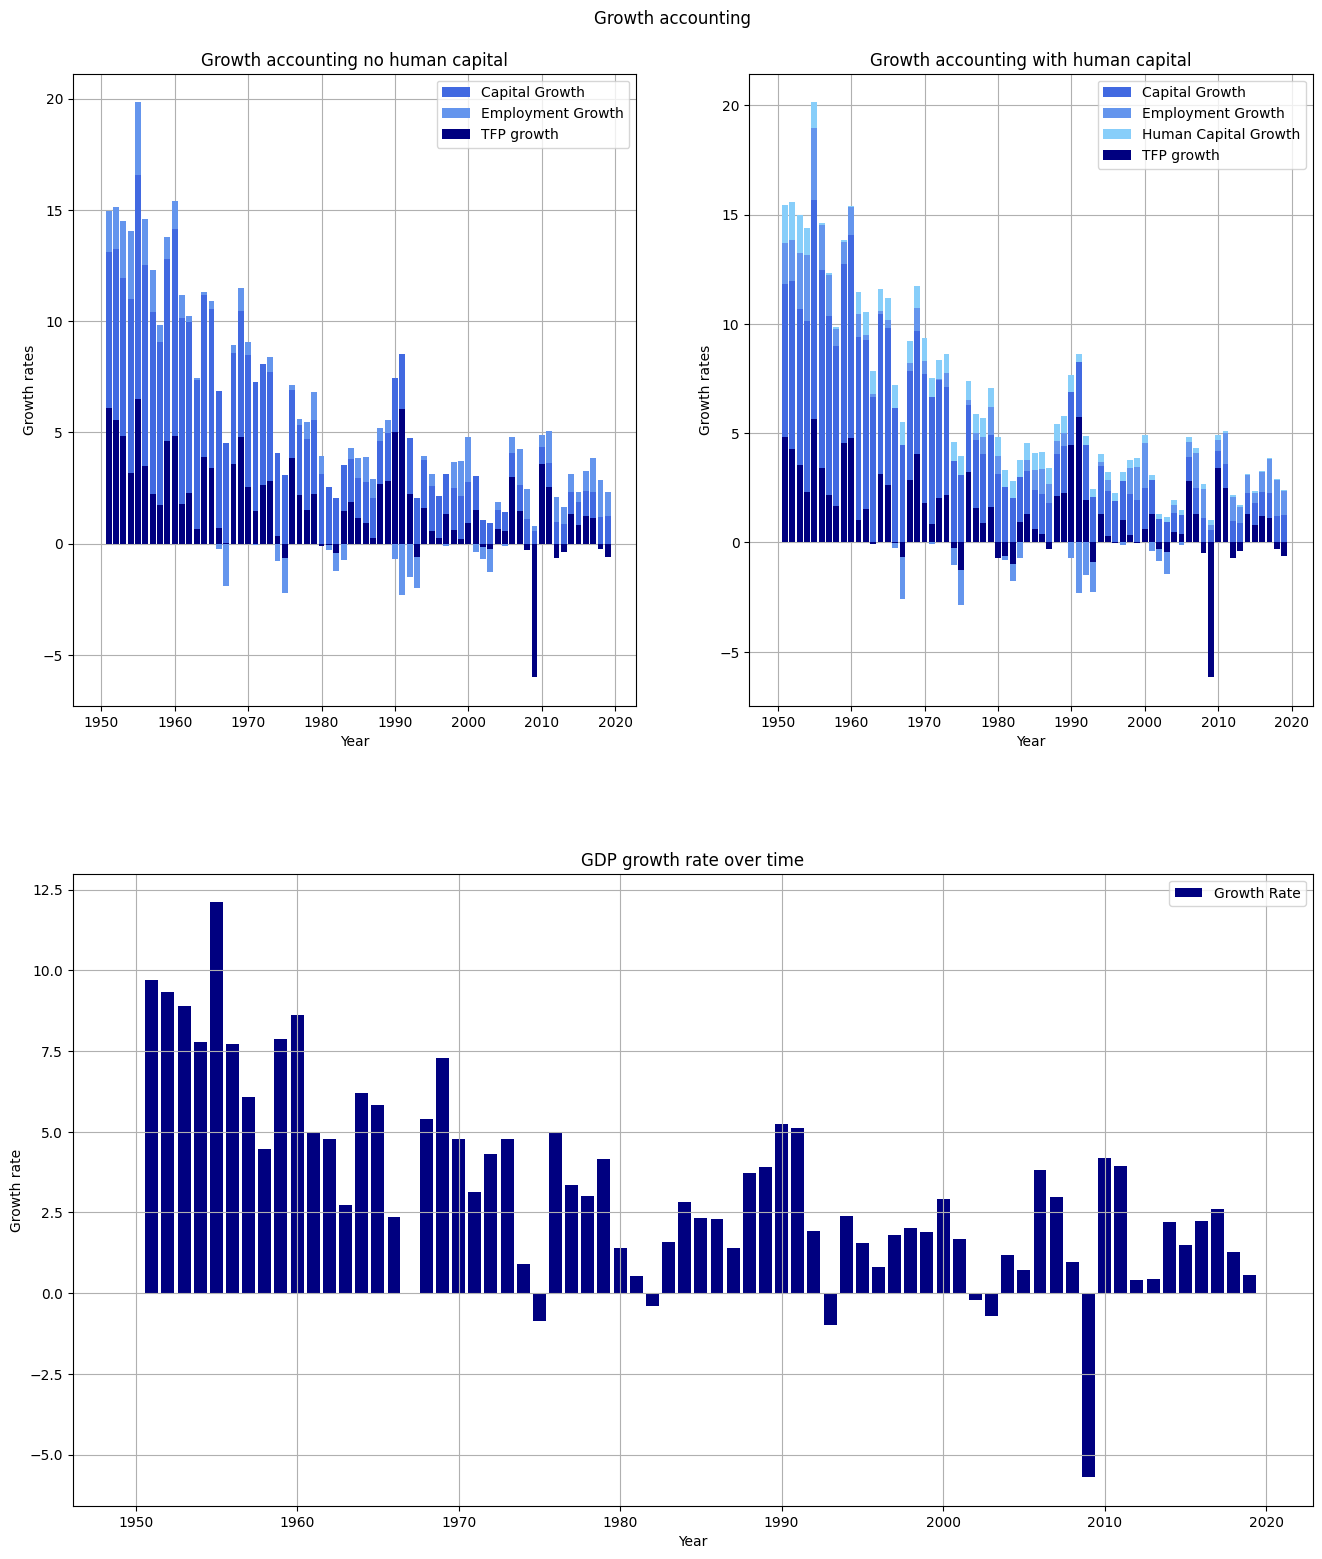

In [ ]:
# Calculate the variable growth rates over time

time=len(year)

# Initialise new arrays
tfp_growth = np.zeros(time)
tfp_hc_growth = np.zeros(time)
rnna_growth = np.zeros(time)
hc_growth = np.zeros(time)
emp_growth = np.zeros(time)
rgdpna_growth = np.zeros(time)
rgdpna_pc_growth = np.zeros(time)
rgdpna_pw_growth = np.zeros(time)

rgdpna_pw = data["rgdpna_pw"]

# Calculate the growth rates
for t in range(1, time):
  tfp_growth[t] = ((tfp[t] - tfp[t-1]) / tfp[t-1]) * 100
  tfp_hc_growth[t] = ((tfp_hc[t] - tfp_hc[t-1]) / tfp_hc[t-1]) * 100
  rnna_growth[t] = ((rnna[t] - rnna[t-1]) / rnna[t-1]) * 100
  hc_growth[t] = ((hc[t] - hc[t-1]) / hc[t-1]) * 100
  emp_growth[t] = ((emp[t] - emp[t-1]) / emp[t-1]) * 100
  rgdpna_growth[t] = ((rgdpna[t] - rgdpna[t-1]) / rgdpna[t-1]) * 100
  rgdpna_pc_growth[t] = ((rgdpna_pc[t] - rgdpna_pc[t-1]) / rgdpna_pc[t-1]) * 100
  rgdpna_pw_growth[t] = ((rgdpna_pw[t] - rgdpna_pw[t-1]) / rgdpna_pw[t-1]) * 100

# Use the growth_accounting_plot() function to plot the bar graphs for the model with human capital and the model without human capital
fig = plt.figure(figsize=(16,16))

(fig1, fig2) = fig.subfigures(2,1)

(ax1, ax2) = fig1.subplots(1,2)

fig1.suptitle("Growth accounting")
fig1.subplots_adjust(wspace=.2, hspace=0.2, top=0.9)

growth_accounting_plot(ax1, tfp_growth, rnna_growth, emp_growth)
ax1.set_title("Growth accounting no human capital")
ax1.set_xlabel("Year")
ax1.set_ylabel("Growth rates")
ax1.grid(True)
ax1.legend()

growth_accounting_plot(ax2, tfp_hc_growth, rnna_growth, emp_growth, hc_growth)
ax2.set_title("Growth accounting with human capital")
ax2.set_xlabel("Year")
ax2.set_ylabel("Growth rates")
ax2.grid(True)
ax2.legend()

(ax3) = fig2.subplots(1,1)

fig2.subplots_adjust(wspace=.2, hspace=0.2, top=0.9)

ax3.bar(data["year"], rgdpna_growth, label="Growth Rate", color="navy")
ax3.set_title("GDP growth rate over time")
ax3.set_xlabel("Year")
ax3.set_ylabel("Growth rate")
ax3.grid(True)
ax3.legend()

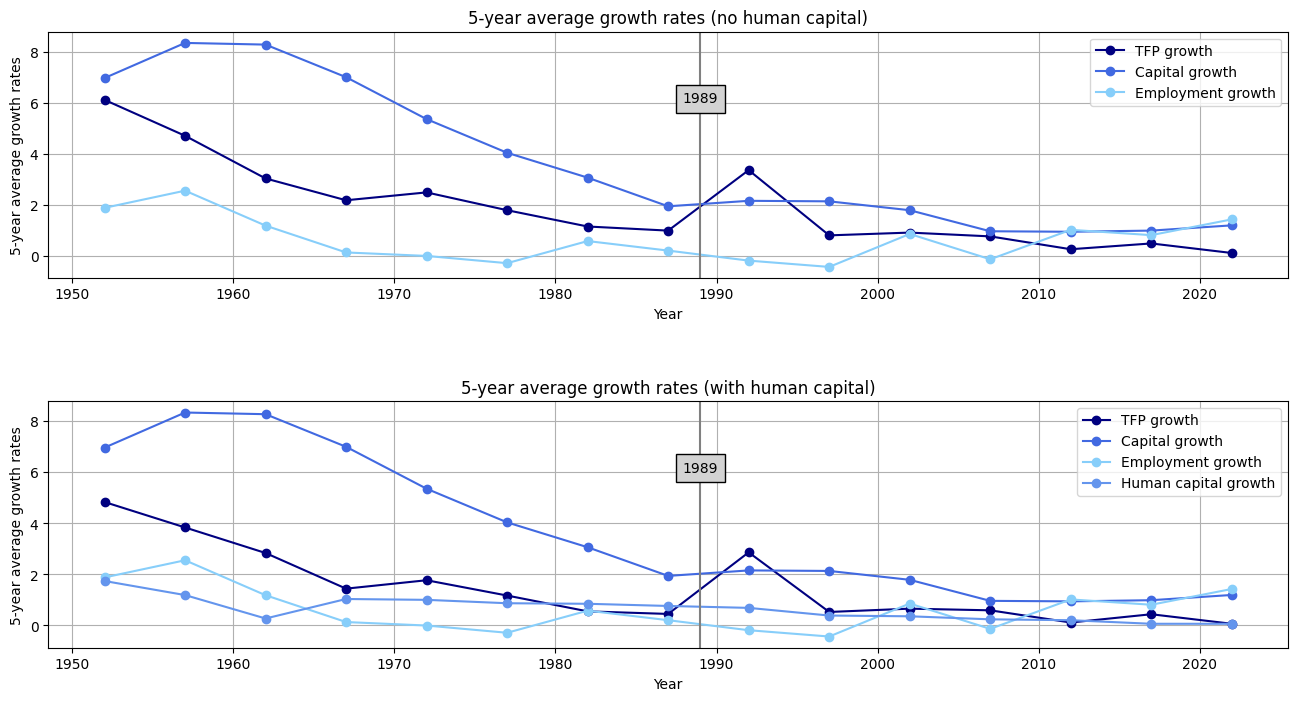

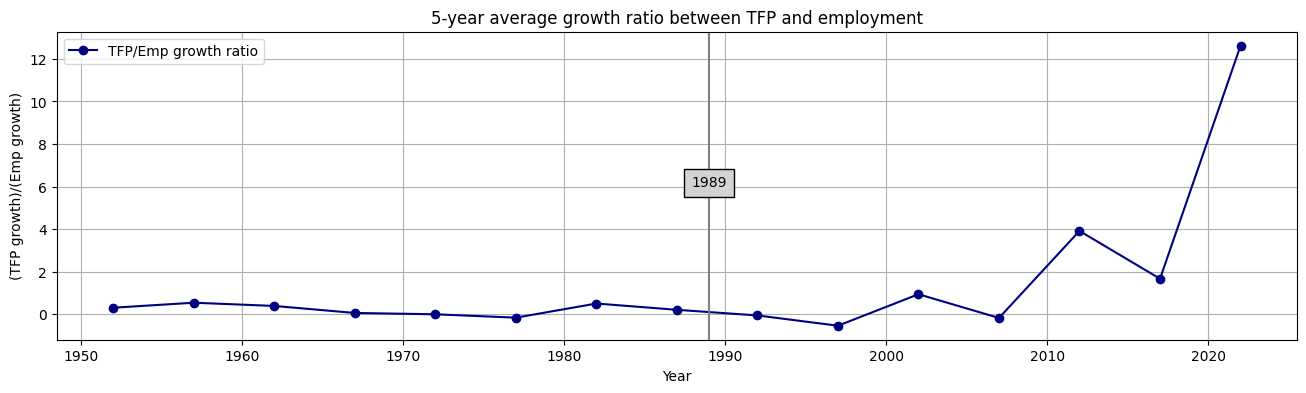

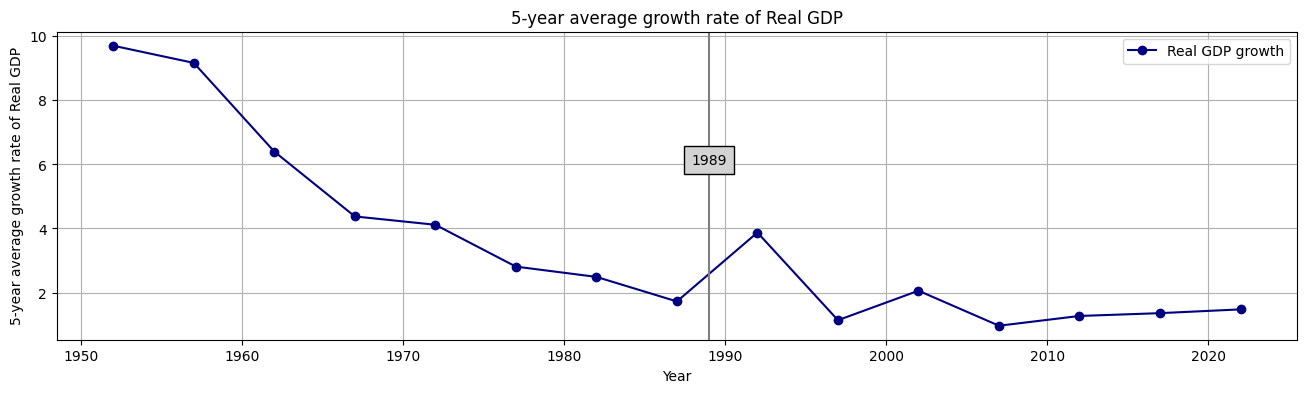

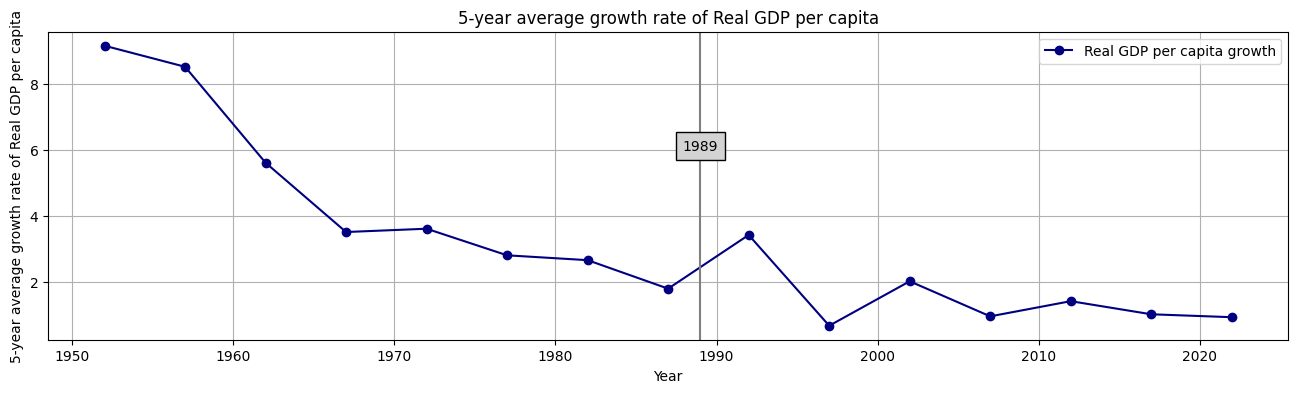

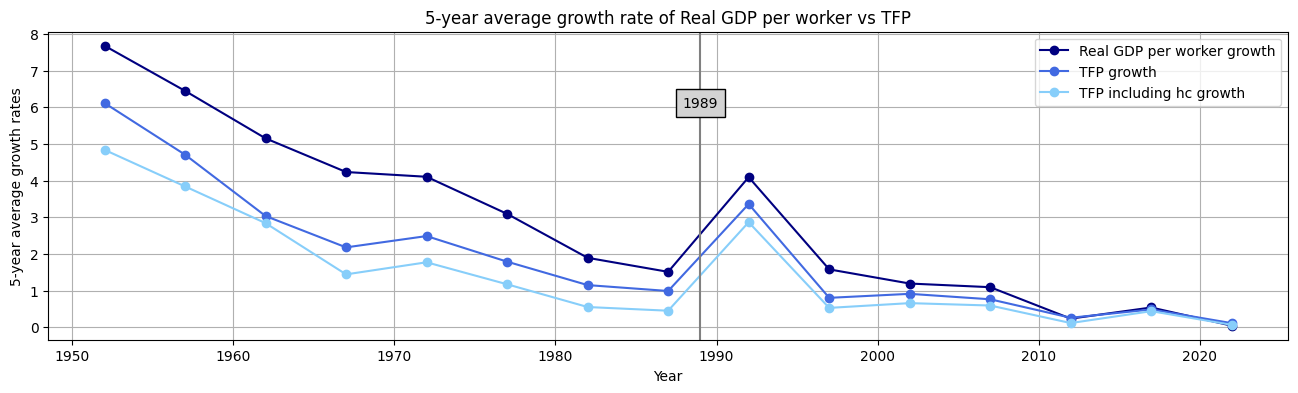

In [ ]:
GA_data = [tfp_growth, tfp_hc_growth, rnna_growth, hc_growth, emp_growth, rgdpna_growth, rgdpna_pw_growth]
GA_df = pd.DataFrame({
    "tfp_growth": tfp_growth,
    "tfp_hc_growth": tfp_hc_growth,
    "rnna_growth": rnna_growth,
    "hc_growth": hc_growth,
    "emp_growth": emp_growth,
    "rgdpna_growth": rgdpna_growth,
    "rgdpna_pc_growth": rgdpna_pc_growth,
    "rgdpna_pw_growth": rgdpna_pw_growth,
})

GA_df = GA_df.drop(GA_df.index[0])

GA_df.index = year[1:]
GA_df.index = pd.to_datetime(GA_df.index, format='%Y')
GA_df_5year = GA_df.resample('5Y').mean()

GA_df_5year.insert(7, "tfp_emp_growth_ratio", GA_df_5year["emp_growth"] / GA_df_5year["tfp_growth"])

fig = plt.figure(figsize = (16,8))

(ax1, ax2) = fig.subplots(2,1)

ax1.plot(GA_df_5year.index, GA_df_5year["tfp_growth"], label="TFP growth", color="navy", marker="o")
ax1.plot(GA_df_5year.index, GA_df_5year["rnna_growth"], label="Capital growth", color="royalblue", marker="o")
ax1.plot(GA_df_5year.index, GA_df_5year["emp_growth"], label="Employment growth", color="lightskyblue", marker="o")
ax1.set_title("5-year average growth rates (no human capital)")
ax1.set_xlabel("Year")
ax1.set_ylabel("5-year average growth rates")
ax1.grid(True)
ax1.axvline(pd.to_datetime('1989-01-01'), color="gray")
ax1.text(pd.to_datetime("1989-01-01"), 6, "1989", bbox ={'facecolor':'lightgray','alpha':1,'pad':5}, horizontalalignment = 'center')
ax1.legend()

ax2.plot(GA_df_5year.index, GA_df_5year["tfp_hc_growth"], label="TFP growth", color="navy", marker="o")
ax2.plot(GA_df_5year.index, GA_df_5year["rnna_growth"], label="Capital growth", color="royalblue", marker="o")
ax2.plot(GA_df_5year.index, GA_df_5year["emp_growth"], label="Employment growth", color="lightskyblue", marker="o")
ax2.plot(GA_df_5year.index, GA_df_5year["hc_growth"], label="Human capital growth", color="cornflowerblue", marker="o")
ax2.set_title("5-year average growth rates (with human capital)")
ax2.set_xlabel("Year")
ax2.set_ylabel("5-year average growth rates")
ax2.grid(True)
ax2.axvline(pd.to_datetime('1989-01-01'), color="gray")
ax2.text(pd.to_datetime("1989-01-01"), 6, "1989", bbox ={'facecolor':'lightgray','alpha':1,'pad':5}, horizontalalignment = 'center')
ax2.legend()

plt.subplots_adjust(hspace=0.5)

fig = plt.figure(figsize=(16,4))

ax = fig.subplots(1,1)

ax.plot(GA_df_5year.index, GA_df_5year["tfp_emp_growth_ratio"], label="TFP/Emp growth ratio", color="navy", marker="o")
ax.set_title("5-year average growth ratio between TFP and employment")
ax.set_xlabel("Year")
ax.set_ylabel("(TFP growth)/(Emp growth)")
ax.grid(True)
ax.axvline(pd.to_datetime('1989-01-01'), color="gray")
ax.text(pd.to_datetime("1989-01-01"), 6, "1989", bbox ={'facecolor':'lightgray','alpha':1,'pad':5}, horizontalalignment = 'center')
ax.legend()

fig = plt.figure(figsize=(16,4))

ax = fig.subplots(1,1)

ax.plot(GA_df_5year.index, GA_df_5year["rgdpna_growth"], label="Real GDP growth", color="navy", marker="o")
ax.set_title("5-year average growth rate of Real GDP")
ax.set_xlabel("Year")
ax.set_ylabel("5-year average growth rate of Real GDP")
ax.grid(True)
ax.axvline(pd.to_datetime('1989-01-01'), color="gray")
ax.text(pd.to_datetime("1989-01-01"), 6, "1989", bbox ={'facecolor':'lightgray','alpha':1,'pad':5}, horizontalalignment = 'center')
ax.legend()

fig = plt.figure(figsize=(16,4))

ax = fig.subplots(1,1)

ax.plot(GA_df_5year.index, GA_df_5year["rgdpna_pc_growth"], label="Real GDP per capita growth", color="navy", marker="o")
ax.set_title("5-year average growth rate of Real GDP per capita")
ax.set_xlabel("Year")
ax.set_ylabel("5-year average growth rate of Real GDP per capita")
ax.grid(True)
ax.axvline(pd.to_datetime('1989-01-01'), color="gray")
ax.text(pd.to_datetime("1989-01-01"), 6, "1989", bbox ={'facecolor':'lightgray','alpha':1,'pad':5}, horizontalalignment = 'center')
ax.legend()

fig = plt.figure(figsize=(16,4))

ax = fig.subplots(1,1)

ax.plot(GA_df_5year.index, GA_df_5year["rgdpna_pw_growth"], label="Real GDP per worker growth", color="navy", marker="o")
ax.plot(GA_df_5year.index, GA_df_5year["tfp_growth"], label="TFP growth", color="royalblue", marker="o")
ax.plot(GA_df_5year.index, GA_df_5year["tfp_hc_growth"], label="TFP including hc growth", color="lightskyblue", marker="o")
ax.set_title("5-year average growth rate of Real GDP per worker vs TFP")
ax.set_xlabel("Year")
ax.set_ylabel("5-year average growth rates")
ax.grid(True)
ax.axvline(pd.to_datetime('1989-01-01'), color="gray")
ax.text(pd.to_datetime("1989-01-01"), 6, "1989", bbox ={'facecolor':'lightgray','alpha':1,'pad':5}, horizontalalignment = 'center')
ax.legend()

Text(0.5, 1.0, 'Growth rates with human capital')

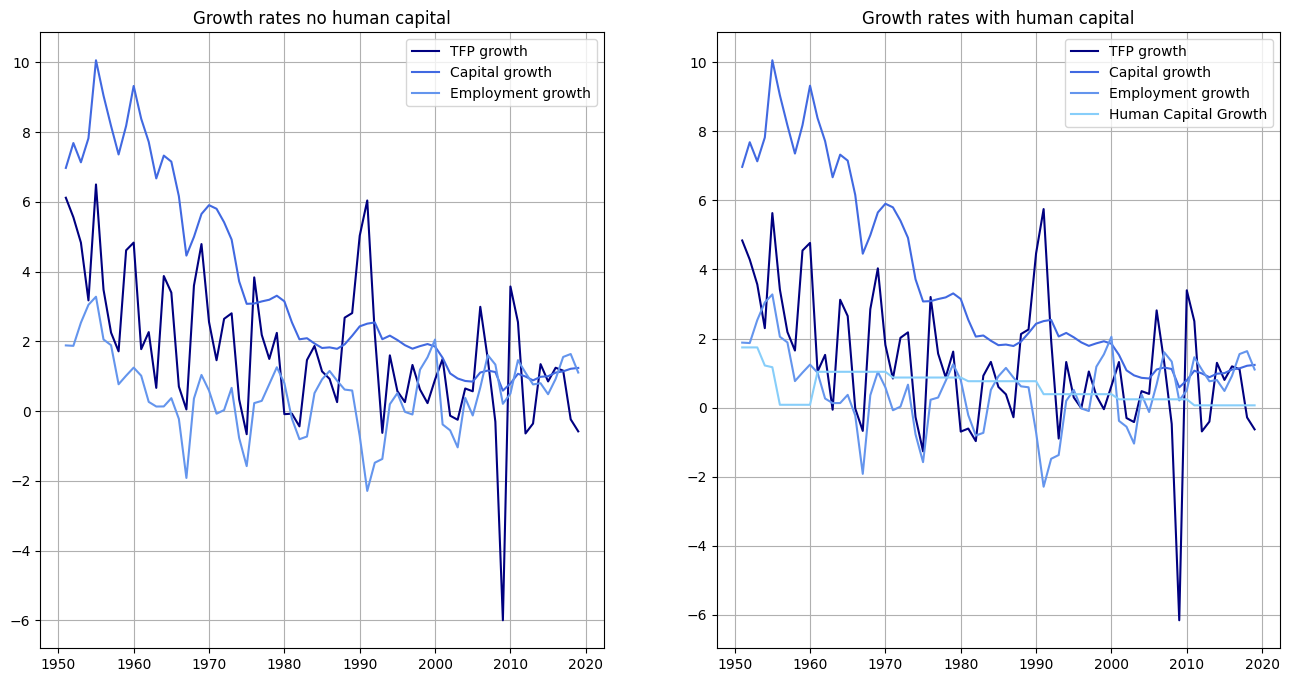

In [ ]:
# Examine the growth rates over time to get an idea of the long run trend

fig = plt.figure(figsize=(16,8))

(ax1, ax2) = fig.subplots(1,2)

ax1.plot(year[1:], tfp_growth[1:], label="TFP growth", color="navy")
ax1.plot(year[1:], rnna_growth[1:], label="Capital growth", color="royalblue")
ax1.plot(year[1:], emp_growth[1:], label="Employment growth", color="cornflowerblue")
ax1.grid(True)
ax1.legend()
ax1.set_title("Growth rates no human capital")

ax2.plot(year[1:], tfp_hc_growth[1:], label="TFP growth", color="navy")
ax2.plot(year[1:], rnna_growth[1:], label="Capital growth", color="royalblue")
ax2.plot(year[1:], emp_growth[1:], label="Employment growth", color="cornflowerblue")
ax2.plot(year[1:], hc_growth[1:], label="Human Capital Growth", color="lightskyblue")
ax2.grid(True)
ax2.legend()
ax2.set_title("Growth rates with human capital")

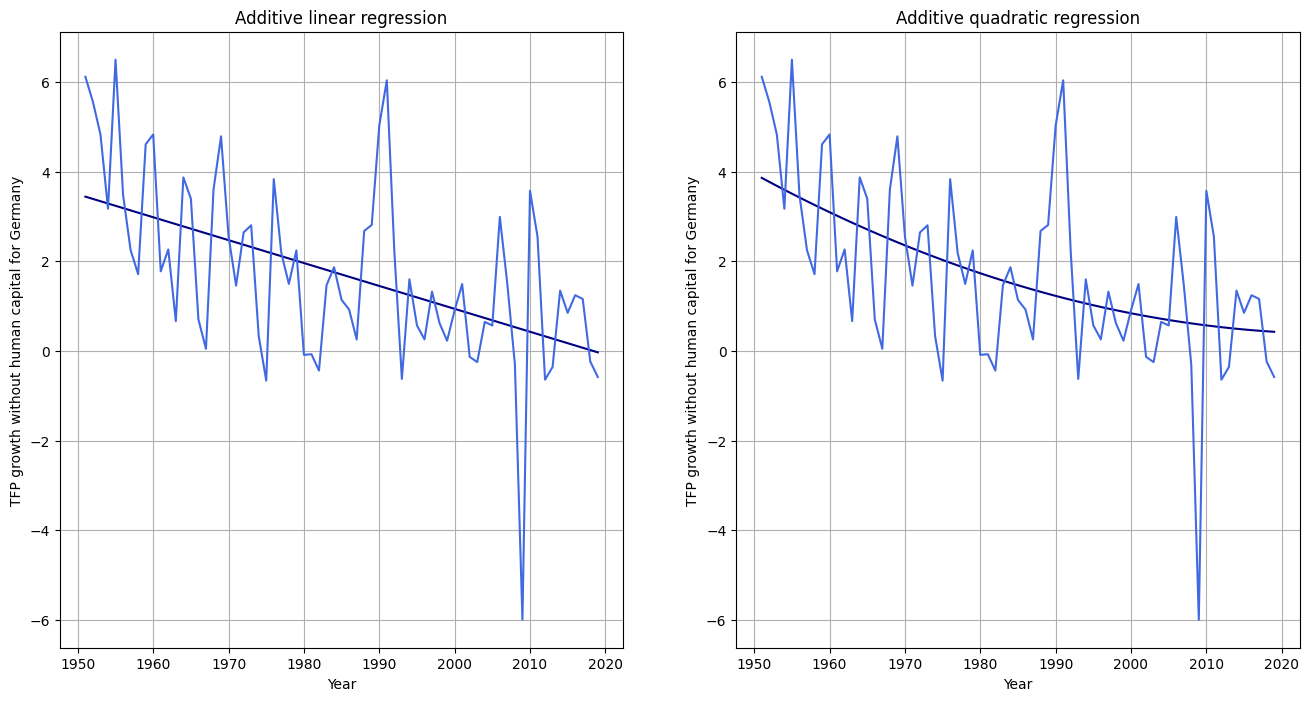

In [ ]:
# Regress TFP (from model without human capital) over time to determine its expected long run behaviour

Y = tfp_growth
T = len(Y)

# Additive linear Model: y = a + bt + u
x1 = np.empty(T)
x2 = np.empty(T)

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1

a_add_lin, b_add_lin = regression_coefs(Y, x1, x2)

tfp_growth_add_lin = np.empty(T)

for t in range(T):
    tfp_growth_add_lin[t] = a_add_lin + b_add_lin * (t + 1)

# Additive quadratic Model: y = a + bt + ct^2 + u
x1, x2, x3 = [np.empty(T) for j in range(3)]

for t in range(T):
    x1[t] = 1.
    x2[t] = t+1
    x3[t] = t**2

a_add_quad, b1_add_quad, b2_add_quad = regression_coefs(Y, x1, x2, x3)

tfp_growth_add_quad = np.empty(T)

for t in range(T):
    tfp_growth_add_quad[t] = a_add_quad + b1_add_quad * (t+1) + b2_add_quad * (t**2)

fig = plt.figure(figsize=(16,8))

(ax1,ax2) = fig.subplots(1,2)

ax1.plot(year[1:], tfp_growth_add_lin[1:], color="navy")
ax1.plot(year[1:], tfp_growth[1:], color="royalblue")
ax1.set_title("Additive linear regression")
ax1.set_xlabel("Year")
ax1.set_ylabel("TFP growth without human capital for " + country_selection)
ax1.ticklabel_format(style="plain", axis="y")
ax1.grid(True)

ax2.plot(year[1:], tfp_growth_add_quad[1:], color="navy")
ax2.plot(year[1:], tfp_growth[1:], color="royalblue")
ax2.set_title("Additive quadratic regression")
ax2.set_xlabel("Year")
ax2.set_ylabel("TFP growth without human capital for " + country_selection)
ax2.ticklabel_format(style="plain", axis="y")
ax2.grid(True)


Text(0, 0.5, 'TFP growth rate')

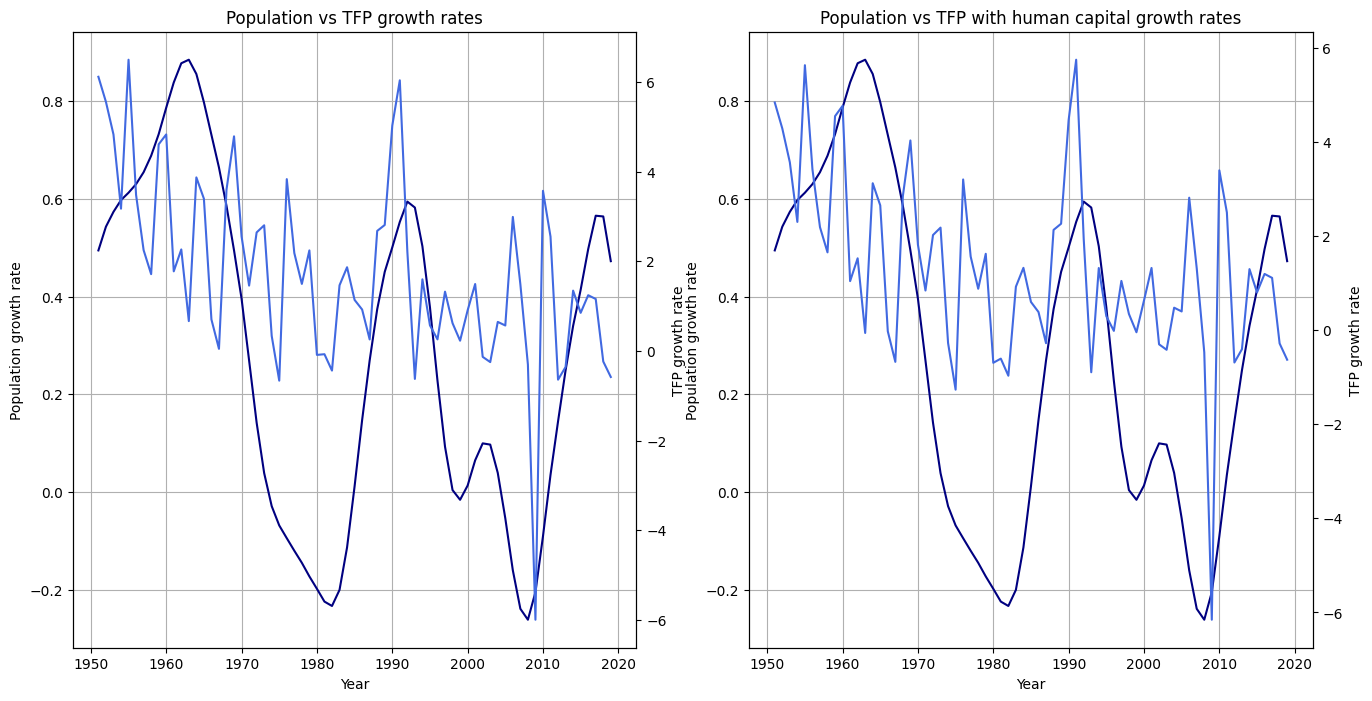

In [ ]:
# TFP growth and population growth together

fig = plt.figure(figsize = (16,8))

(ax1, ax3) = fig.subplots(1,2)

ax1.plot(year[1:], pop_growth[1:], label="Population growth rate", color="navy")
ax1.set_title("Population vs TFP growth rates")
ax1.set_xlabel("Year")
ax1.set_ylabel("Population growth rate")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(year[1:], tfp_growth[1:], label="TFP growth rate", color="royalblue")
ax2.set_ylabel("TFP growth rate")

ax3.plot(year[1:], pop_growth[1:], label="Population level", color="navy")
ax3.set_title("Population vs TFP with human capital growth rates")
ax3.set_xlabel("Year")
ax3.set_ylabel("Population growth rate")
ax3.grid(True)

ax4 = ax3.twinx()
ax4.plot(year[1:], tfp_hc_growth[1:], label="TFP growth rate", color="royalblue")
ax4.set_ylabel("TFP growth rate")

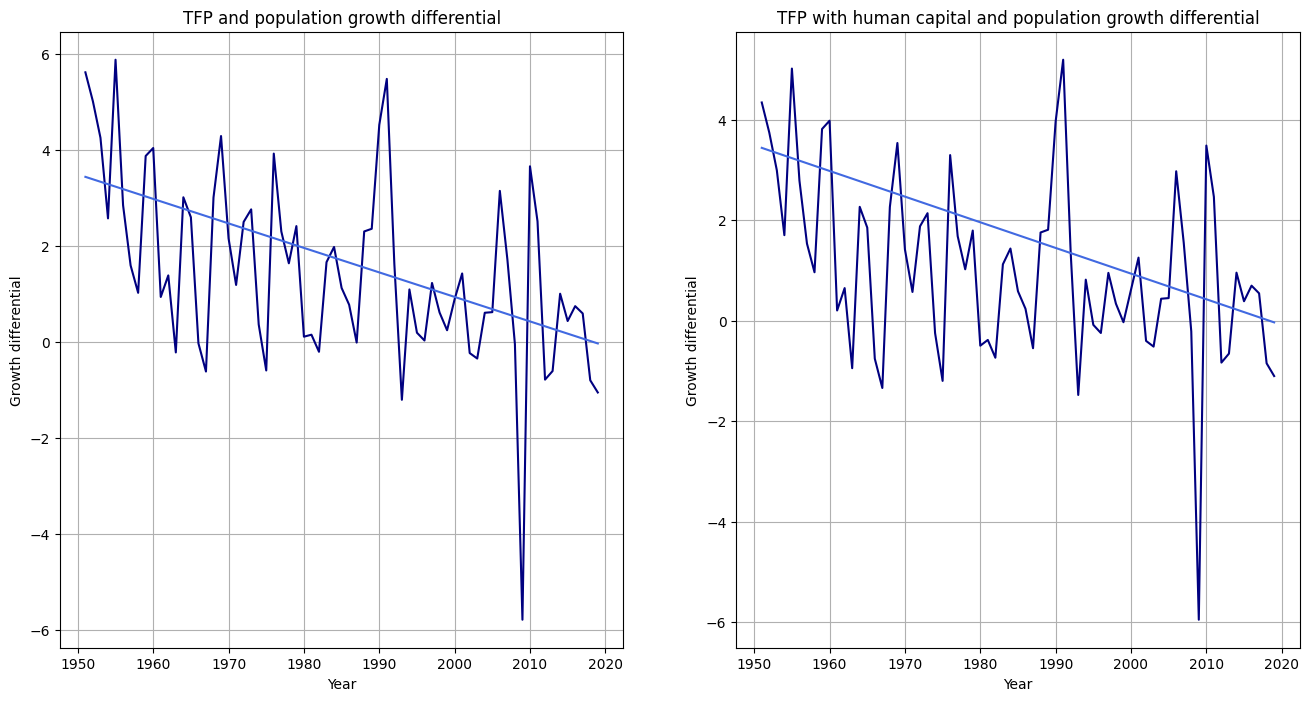

In [ ]:
tfp_pop_growth_diff = np.zeros(time)
tfp_hc_pop_growth_diff = np.zeros(time)

for t in range(1, time):
  tfp_pop_growth_diff[t] = tfp_growth[t] - pop_growth[t]
  tfp_hc_pop_growth_diff[t] = tfp_hc_growth[t] - pop_growth[t]

# Additive linear model for tfp
x1 = np.empty(T)
x2 = np.empty(T)

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1

a_add_lin, b_add_lin = regression_coefs(Y, x1, x2)

tfp_pop_growth_diff_add_lin = np.empty(T)

for t in range(T):
    tfp_pop_growth_diff_add_lin[t] = a_add_lin + b_add_lin * (t + 1)

# Additive linear model for tfp with hc
x1 = np.empty(T)
x2 = np.empty(T)

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1

a_add_lin, b_add_lin = regression_coefs(Y, x1, x2)

tfp_hc_pop_growth_diff_add_lin = np.empty(T)

for t in range(T):
    tfp_hc_pop_growth_diff_add_lin[t] = a_add_lin + b_add_lin * (t + 1)

fig = plt.figure(figsize=(16,8))

(ax1, ax2) = fig.subplots(1,2)

ax1.plot(year[1:], tfp_pop_growth_diff[1:], color="navy")
ax1.plot(year[1:], tfp_pop_growth_diff_add_lin[1:], color="royalblue")
ax1.set_title("TFP and population growth differential")
ax1.set_xlabel("Year")
ax1.set_ylabel("Growth differential")
ax1.grid(True)

ax2.plot(year[1:], tfp_hc_pop_growth_diff[1:], color="navy")
ax2.plot(year[1:], tfp_hc_pop_growth_diff_add_lin[1:], color="royalblue")
ax2.set_title("TFP with human capital and population growth differential")
ax2.set_xlabel("Year")
ax2.set_ylabel("Growth differential")
ax2.grid(True)

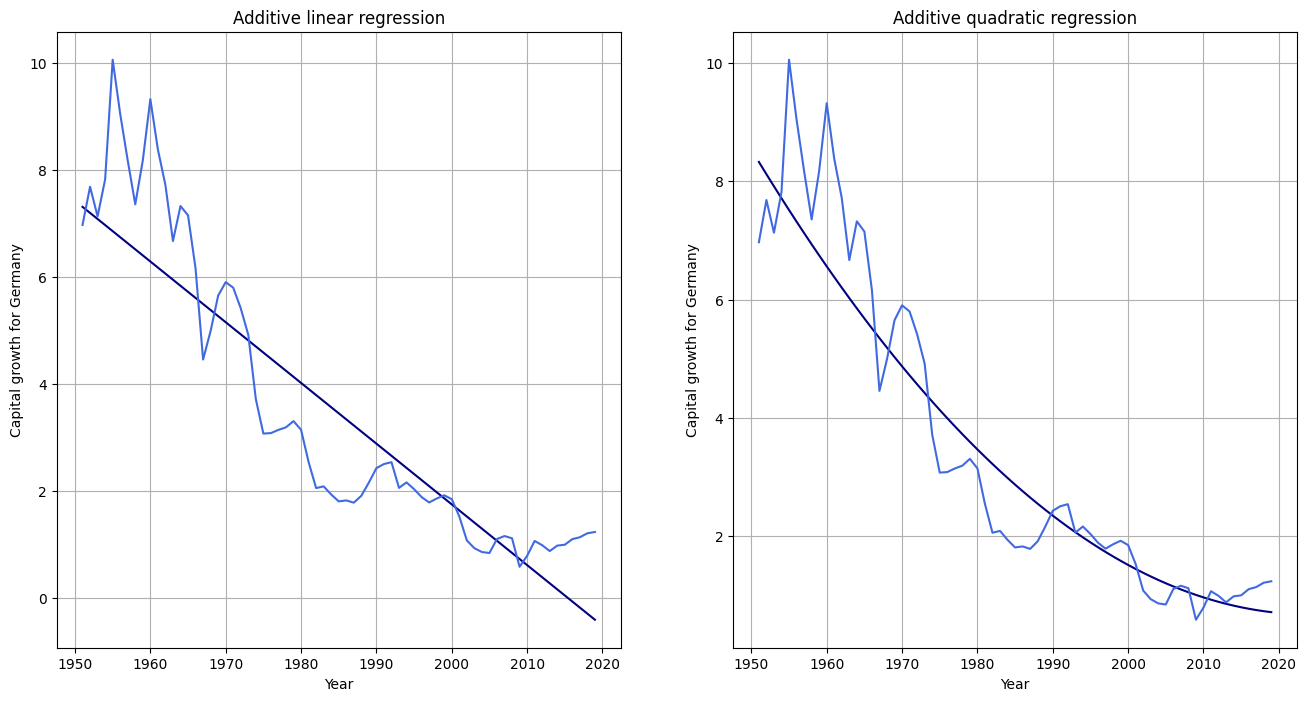

In [ ]:
# Regress capital growth over time to determine its expected long run behaviour

Y = rnna_growth
T = len(Y)

# Additive linear Model: y = a + bt + u
x1 = np.empty(T)
x2 = np.empty(T)

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1

a_add_lin, b_add_lin = regression_coefs(Y, x1, x2)

rnna_growth_add_lin = np.empty(T)

for t in range(T):
    rnna_growth_add_lin[t] = a_add_lin + b_add_lin * (t + 1)

# Additive quadratic Model: y = a + bt + ct^2 + u
x1, x2, x3 = [np.empty(T) for j in range(3)]

for t in range(T):
    x1[t] = 1.
    x2[t] = t+1
    x3[t] = t**2

a_add_quad, b1_add_quad, b2_add_quad = regression_coefs(Y, x1, x2, x3)

rnna_growth_add_quad = np.empty(T)

for t in range(T):
    rnna_growth_add_quad[t] = a_add_quad + b1_add_quad * (t+1) + b2_add_quad * (t**2)

fig = plt.figure(figsize=(16,8))

(ax1,ax2) = fig.subplots(1,2)

ax1.plot(year[1:], rnna_growth_add_lin[1:], color="navy")
ax1.plot(year[1:], rnna_growth[1:], color="royalblue")
ax1.set_title("Additive linear regression")
ax1.set_xlabel("Year")
ax1.set_ylabel("Capital growth for " + country_selection)
ax1.ticklabel_format(style="plain", axis="y")
ax1.grid(True)

ax2.plot(year[1:], rnna_growth_add_quad[1:], color="navy")
ax2.plot(year[1:], rnna_growth[1:], color="royalblue")
ax2.set_title("Additive quadratic regression")
ax2.set_xlabel("Year")
ax2.set_ylabel("Capital growth for " + country_selection)
ax2.ticklabel_format(style="plain", axis="y")
ax2.grid(True)

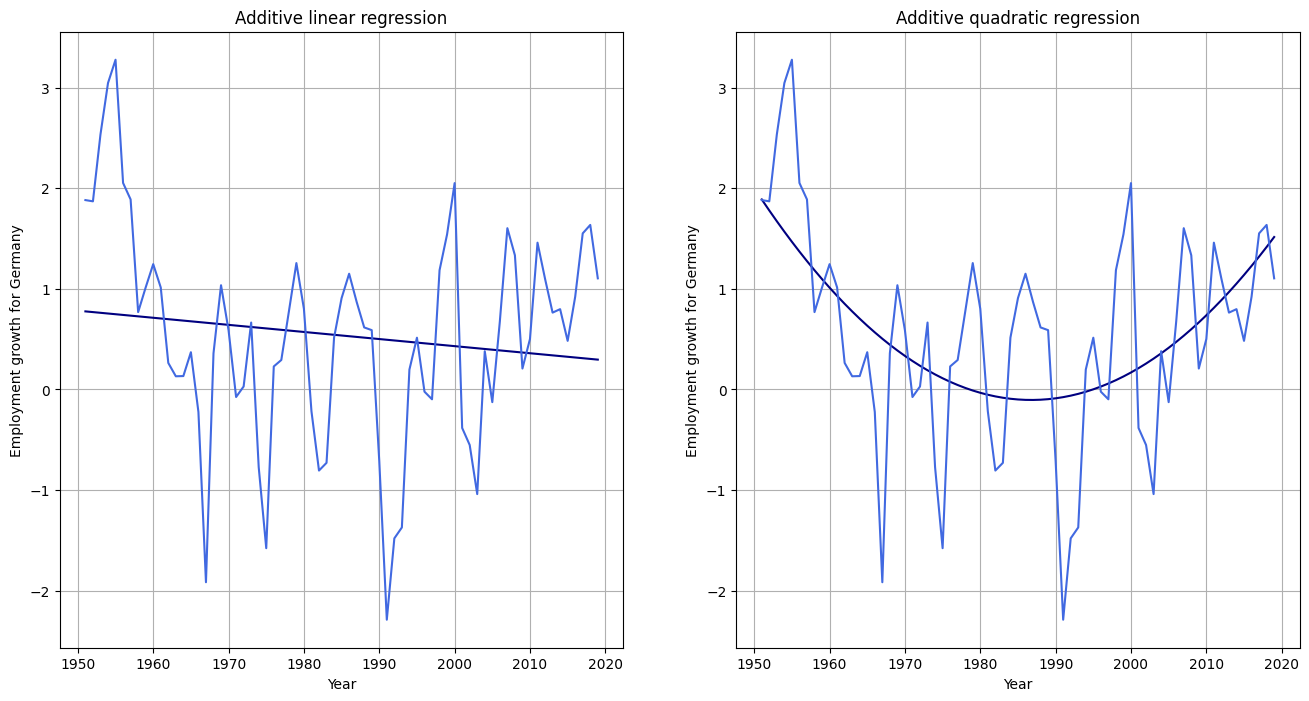

In [ ]:
# Regress employment over time to determine its expected long run behaviour

Y = emp_growth
T = len(Y)

# Calculate each trend line before deciding which is most suitable

# Additive linear Model: y = a + bt + u
x1 = np.empty(T)
x2 = np.empty(T)

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1

a_add_lin, b_add_lin = regression_coefs(Y, x1, x2)

emp_growth_add_lin = np.empty(T)

for t in range(T):
    emp_growth_add_lin[t] = a_add_lin + b_add_lin * (t + 1)

# Additive quadratic Model: y = a + bt + ct^2 + u
x1, x2, x3 = [np.empty(T) for j in range(3)]

for t in range(T):
    x1[t] = 1.
    x2[t] = t+1
    x3[t] = t**2

a_add_quad, b1_add_quad, b2_add_quad = regression_coefs(Y, x1, x2, x3)

emp_growth_add_quad = np.empty(T)

for t in range(T):
    emp_growth_add_quad[t] = a_add_quad + b1_add_quad * (t+1) + b2_add_quad * (t**2)

fig = plt.figure(figsize=(16,8))

(ax1,ax2) = fig.subplots(1,2)

ax1.plot(year[1:], emp_growth_add_lin[1:], color="navy")
ax1.plot(year[1:], emp_growth[1:], color="royalblue")
ax1.set_title("Additive linear regression")
ax1.set_xlabel("Year")
ax1.set_ylabel("Employment growth for " + country_selection)
ax1.ticklabel_format(style="plain", axis="y")
ax1.grid(True)

ax2.plot(year[1:], emp_growth_add_quad[1:], color="navy")
ax2.plot(year[1:], emp_growth[1:], color="royalblue")
ax2.set_title("Additive quadratic regression")
ax2.set_xlabel("Year")
ax2.set_ylabel("Employment growth for " + country_selection)
ax2.ticklabel_format(style="plain", axis="y")
ax2.grid(True)

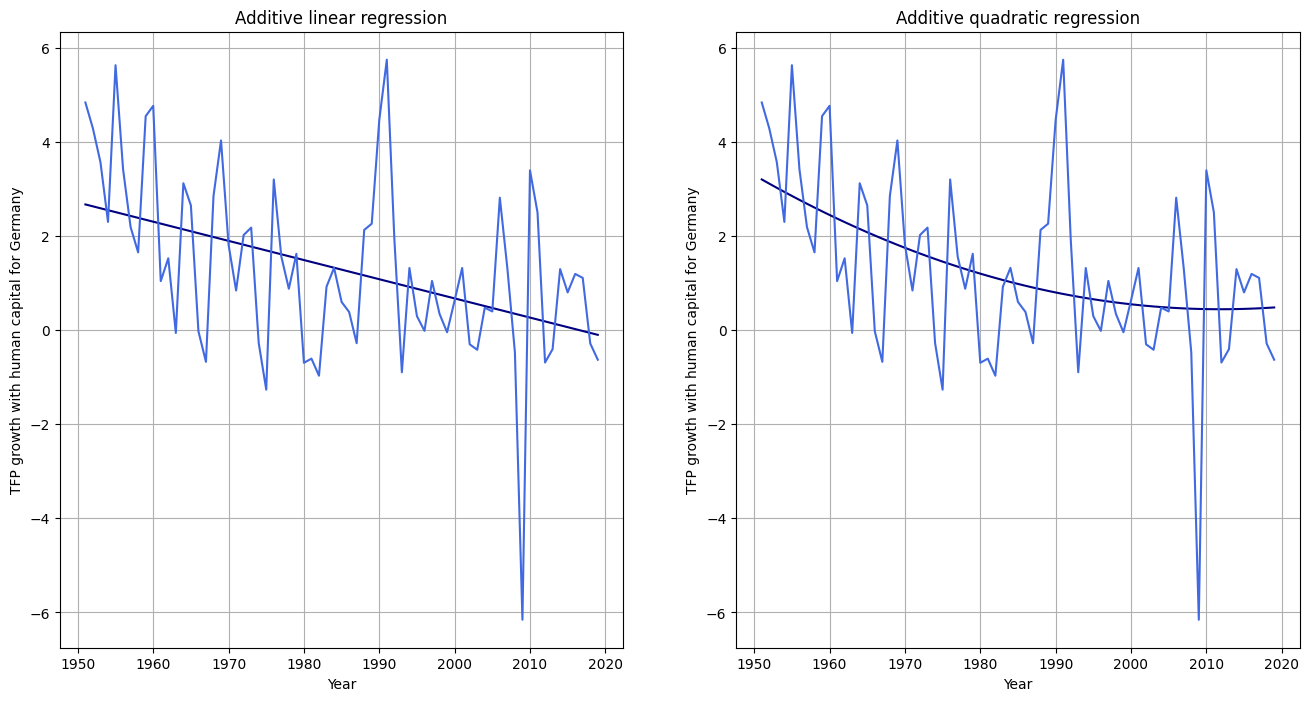

In [ ]:
# Regress TFP (from model with human capital) over time to determine its expected long run behaviour

Y = tfp_hc_growth
T = len(Y)

# Additive linear Model: y = a + bt + u
x1 = np.empty(T)
x2 = np.empty(T)

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1

a_add_lin, b_add_lin = regression_coefs(Y, x1, x2)

tfp_hc_growth_add_lin = np.empty(T)

for t in range(T):
    tfp_hc_growth_add_lin[t] = a_add_lin + b_add_lin * (t + 1)

# Additive quadratic Model: y = a + bt + ct^2 + u
x1, x2, x3 = [np.empty(T) for j in range(3)]

for t in range(T):
    x1[t] = 1.
    x2[t] = t+1
    x3[t] = t**2

a_add_quad, b1_add_quad, b2_add_quad = regression_coefs(Y, x1, x2, x3)

tfp_hc_growth_add_quad = np.empty(T)

for t in range(T):
    tfp_hc_growth_add_quad[t] = a_add_quad + b1_add_quad * (t+1) + b2_add_quad * (t**2)

fig = plt.figure(figsize=(16,8))

(ax1,ax2) = fig.subplots(1,2)

ax1.plot(year[1:], tfp_hc_growth_add_lin[1:], color="navy")
ax1.plot(year[1:], tfp_hc_growth[1:], color="royalblue")
ax1.set_title("Additive linear regression")
ax1.set_xlabel("Year")
ax1.set_ylabel("TFP growth with human capital for " + country_selection)
ax1.ticklabel_format(style="plain", axis="y")
ax1.grid(True)

ax2.plot(year[1:], tfp_hc_growth_add_quad[1:], color="navy")
ax2.plot(year[1:], tfp_hc_growth[1:], color="royalblue")
ax2.set_title("Additive quadratic regression")
ax2.set_xlabel("Year")
ax2.set_ylabel("TFP growth with human capital for " + country_selection)
ax2.ticklabel_format(style="plain", axis="y")
ax2.grid(True)

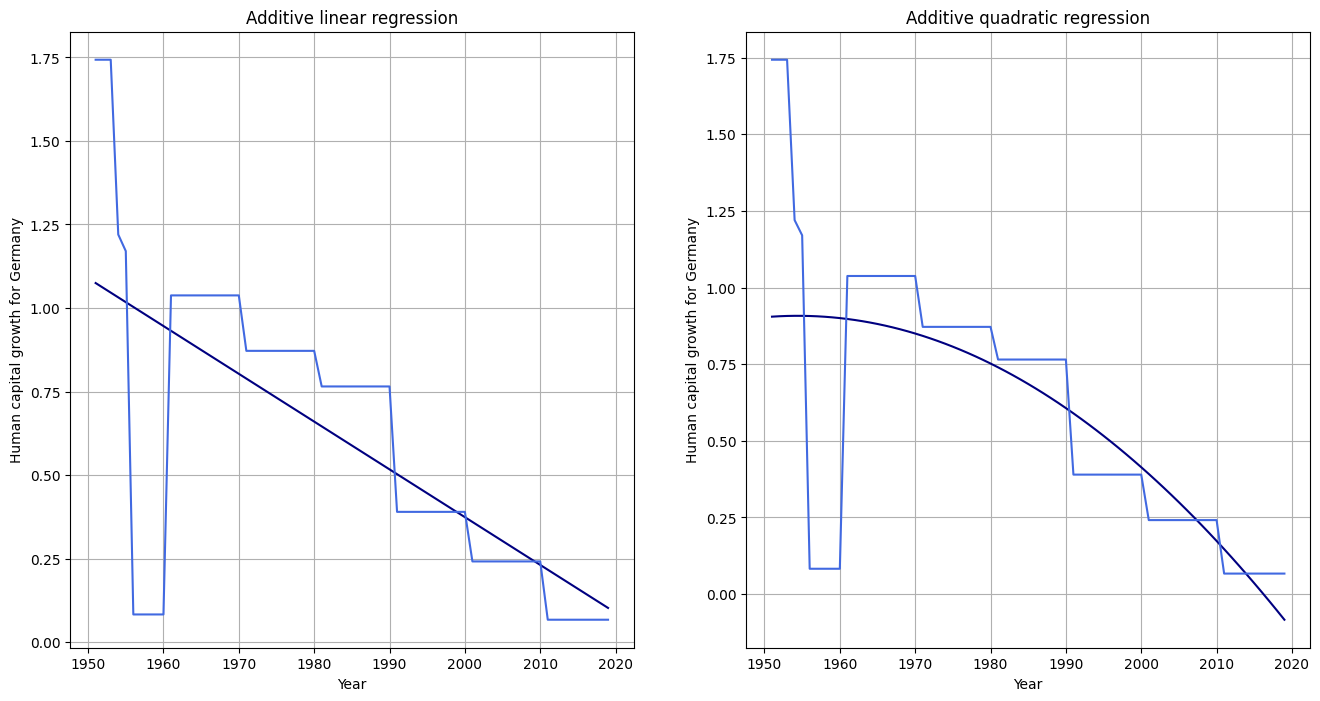

In [ ]:
# Regress human capital growth over time to determine its long run behaviour

Y = hc_growth
T = len(Y)

# Additive linear Model: y = a + bt + u
x1 = np.empty(T)
x2 = np.empty(T)

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1

a_add_lin, b_add_lin = regression_coefs(Y, x1, x2)

hc_growth_add_lin = np.empty(T)

for t in range(T):
    hc_growth_add_lin[t] = a_add_lin + b_add_lin * (t + 1)

# Additive quadratic Model: y = a + bt + ct^2 + u
x1, x2, x3 = [np.empty(T) for j in range(3)]

for t in range(T):
    x1[t] = 1.
    x2[t] = t+1
    x3[t] = t**2

a_add_quad, b1_add_quad, b2_add_quad = regression_coefs(Y, x1, x2, x3)

hc_growth_add_quad = np.empty(T)

for t in range(T):
    hc_growth_add_quad[t] = a_add_quad + b1_add_quad * (t+1) + b2_add_quad * (t**2)

fig = plt.figure(figsize=(16,8))

(ax1,ax2) = fig.subplots(1,2)

ax1.plot(year[1:], hc_growth_add_lin[1:], color="navy")
ax1.plot(year[1:], hc_growth[1:], color="royalblue")
ax1.set_title("Additive linear regression")
ax1.set_xlabel("Year")
ax1.set_ylabel("Human capital growth for " + country_selection)
ax1.ticklabel_format(style="plain", axis="y")
ax1.grid(True)

ax2.plot(year[1:], hc_growth_add_quad[1:], color="navy")
ax2.plot(year[1:], hc_growth[1:], color="royalblue")
ax2.set_title("Additive quadratic regression")
ax2.set_xlabel("Year")
ax2.set_ylabel("Human capital growth for " + country_selection)
ax2.ticklabel_format(style="plain", axis="y")
ax2.grid(True)

# **Labour Productivity**

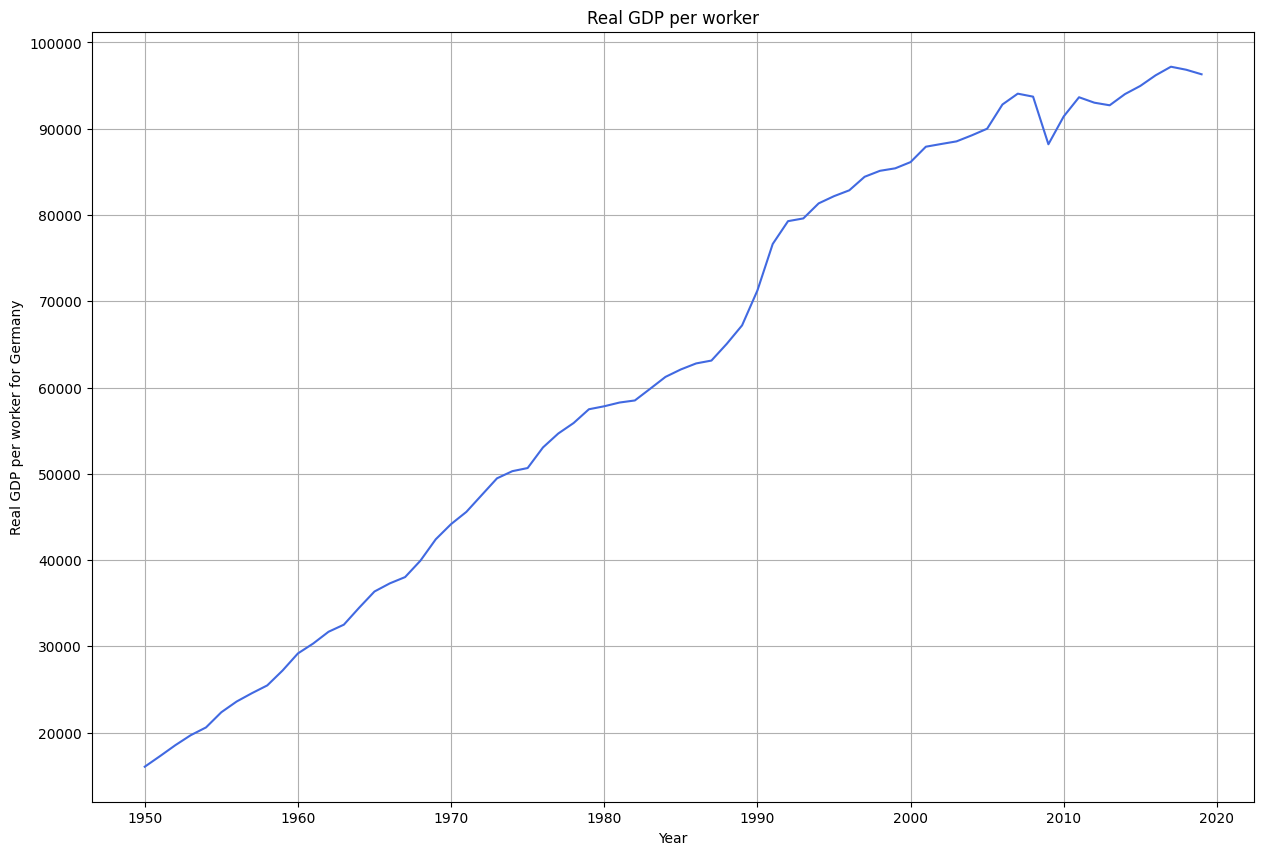

In [ ]:
# GDP per worker time series

fig = plt.figure(figsize=(15,10))

ax = fig.subplots(1,1)

ax.plot(data["year"], data["rgdpna_pw"], color="royalblue")
ax.set_ylabel("Real GDP per worker for " + country_selection)
ax.set_xlabel("Year")
ax.set_title("Real GDP per worker")
ax.grid(True)

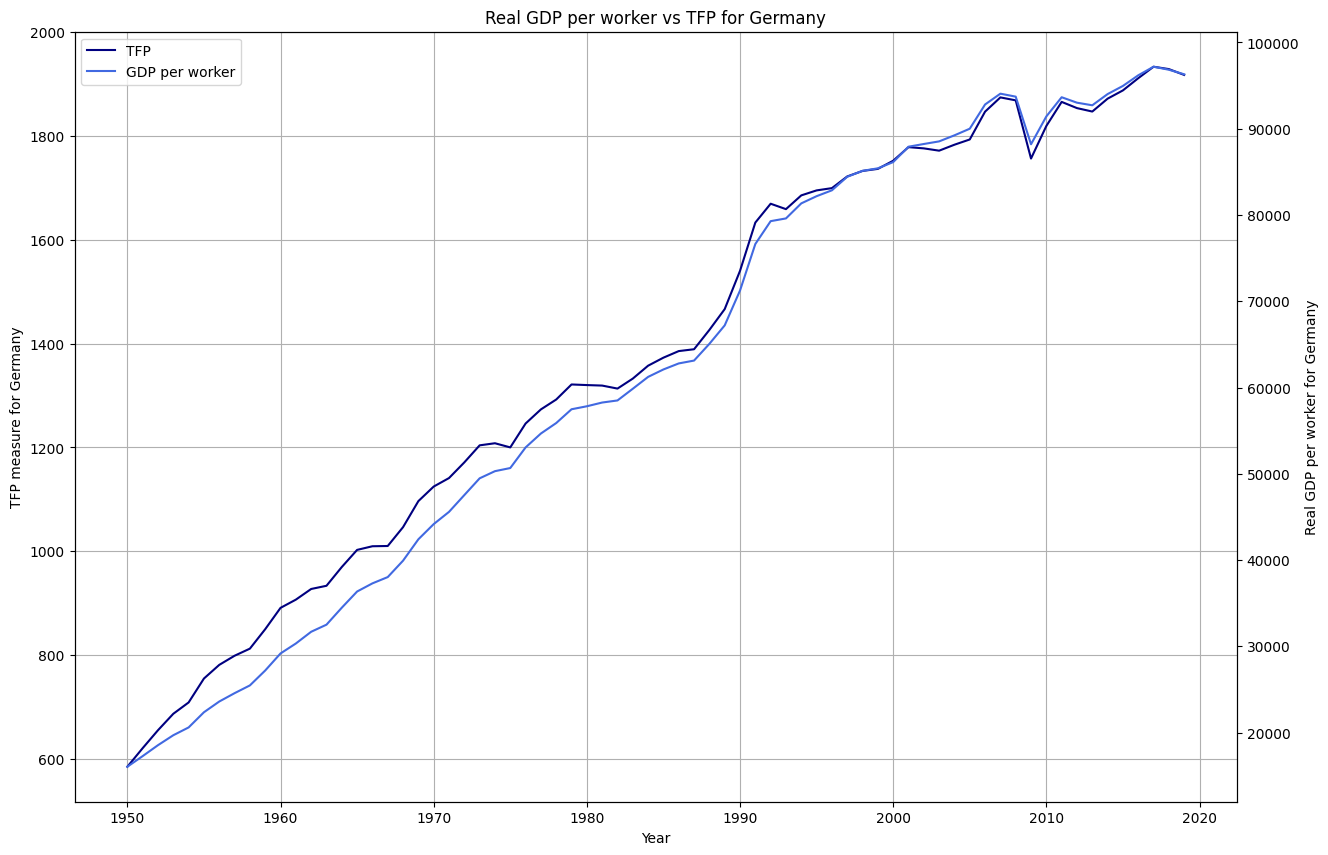

In [ ]:
fig = plt.figure(figsize=(15,10))

ax = fig.subplots(1,1)

ax.plot(data["year"], data["TFP"], label="TFP", color="navy")
ax.set_ylabel("TFP measure for " + country_selection)
ax.set_xlabel("Year")
ax.set_title("Real GDP per worker vs TFP for " + country_selection)
ax.grid(True)

ax1 = ax.twinx()
ax1.plot(data["year"], data["rgdpna_pw"], label="GDP per worker", color="royalblue")
ax1.set_ylabel("Real GDP per worker for " + country_selection)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2)